In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings

In [14]:
df = pd.read_csv('C:/Users/pc/Desktop/Elevate Labs/project/sales_data_sample.csv', encoding='latin1')
print("Initial data loaded.")
print(f"Total records: {len(df)}")

Initial data loaded.
Total records: 2823


In [15]:
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])
df['DISCOUNT_IMPLIED'] = (df['MSRP'] - df['PRICEEACH']) / df['MSRP']
df['DISCOUNT_IMPLIED'] = df['DISCOUNT_IMPLIED'].apply(lambda x: max(0, x))

In [16]:
df['return_prob_base'] = 0.05
discount_threshold = df['DISCOUNT_IMPLIED'].quantile(0.8)
df.loc[df['DISCOUNT_IMPLIED'] > discount_threshold, 'return_prob_base'] += 0.10
df.loc[df['STATUS'].isin(['Disputed', 'Cancelled']), 'return_prob_base'] += 0.25
np.random.seed(42)
df['is_returned'] = np.random.binomial(n=1, p=df['return_prob_base'])

print(f"Synthetic Return Rate: {df['is_returned'].mean()*100:.2f}%")

Synthetic Return Rate: 8.40%


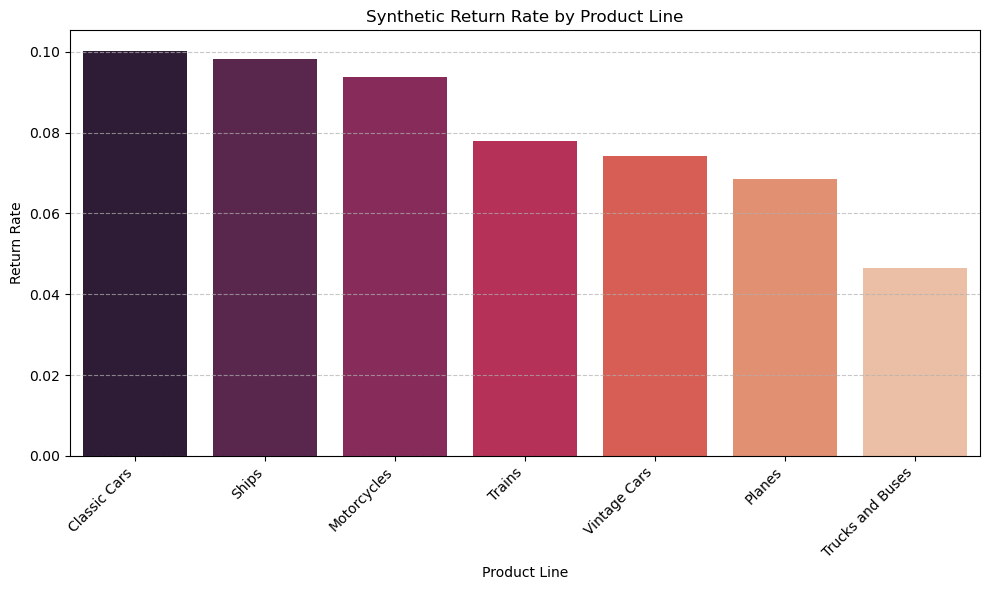

In [17]:
product_return_rate = df.groupby('PRODUCTLINE')['is_returned'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=product_return_rate.index, y=product_return_rate.values, palette="rocket")
plt.title('Synthetic Return Rate by Product Line')
plt.ylabel('Return Rate')
plt.xlabel('Product Line')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [19]:

X_temp = df.drop('is_returned', axis=1)

X_full = pd.get_dummies(X_temp, columns=categorical_features, drop_first=True)
y = df['is_returned']

non_numeric_cols = X_full.select_dtypes(include=['object']).columns.tolist()
columns_to_exclude = [
    'ORDERNUMBER', 'ORDERDATE', 'return_prob_base'
] + non_numeric_cols
X_full = X_full.drop(columns=[col for col in columns_to_exclude if col in X_full.columns])
print("Feature set X_full cleaned. Dimensions:", X_full.shape)
scaler = StandardScaler()
X_full[numerical_features] = scaler.fit_transform(X_full[numerical_features])
model = LogisticRegression(max_iter=1000)
model.fit(X_full, y) 
df['Return_Risk_Score'] = model.predict_proba(X_full)[:, 1]

print("Model successfully trained and risk scores generated!")

Feature set X_full cleaned. Dimensions: (2823, 41)
Model successfully trained and risk scores generated!


In [20]:


# Export the full dataset for Power BI dashboard
df.to_csv( r'C:\Users\pc\Desktop\\SalesData_with_RiskScore.csv', index=False)

# Export High-Risk Products list
high_risk_products = df.groupby(['PRODUCTLINE', 'PRODUCTCODE']).agg(
    {'Return_Risk_Score': 'mean', 'SALES': 'sum'}
).reset_index().sort_values(by='Return_Risk_Score', ascending=False).head(50)

high_risk_products.to_csv( r'C:\Users\pc\Desktop\\Top_50_High_Risk_Products_v2.csv', index=False)

print("\n✅ Files exported to your Desktop.")


✅ Files exported to your Desktop.
